# Correlation between the number of train stations per square km and the number of cars per 1000 people in a community

Florian Oberndörfer
08.01.2024

## Introduction
In days of global climate change, it gets more and more important to go climate friendly. One possibility to do this is by using the train instead of the car. Or in the best case not even having a car.
So the aim of this project is to find out, whether the number of train stations per square km has an influence on the number of cars per 1000 residents in this county.
So if the answer to this question would be true, it could be a possibility to build more train stations in order to decrease the number of cars and so become more climate friendly.


## Methods
### Datasources

#### Datasource 1: Train stations per zip code
* Metadata URL: https://data.deutschebahn.com/dataset/data-stationsdaten/resource/dfddd39b-b74c-40b7-9b60-d265ee2473cb.html
* Data URL: https://download-data.deutschebahn.com/static/datasets/stationsdaten/DBSuS-Uebersicht_Bahnhoefe-Stand2020-03.csv
* Data Type: CSV

Dataset which lists the existing train stations in Germany with the corresponding zip code.

#### Datasource 2: Residents and area per zip code
* Metadata URL: https://www.suche-postleitzahl.org/downloads
* Data URL: https://downloads.suche-postleitzahl.org/v2/public/plz_einwohner.csv
* Data Type: CSV

Dataset which contains the number of residents and the area in square km per zip code.
#### Datasource 3: Number of cars per county
* Metadata URL: https://mobilithek.info/offers/-7245790047701635178
* Data URL: https://www-genesis.destatis.de/genesis/downloads/00/tables/46251-0020_00.csv
* Data Type: CSV

Dataset which contains the number of cars per county.
License: dl-de/by-2-0 (http://www.govdata.de/dl-de/by-2-0)

#### Datasource 4: Allocation table for zip code and county 
* Metadata URL: https://www.suche-postleitzahl.org/downloads
* Data URL: https://downloads.suche-postleitzahl.org/v2/public/zuordnung_plz_ort.csv
* Data Type: CSV

Dataset which shows, which zip code belongs to which county.
This dataset is needed, because the number of cars is listed by county, but the train stations, number of residents and area is listed by zip code. 

### Data Pipeline
The data pipeline is divided into three steps.
#### 1. Getting data
In the first step data is fetched from the internet, the needed columns are selected, renamed and then converted to a pandas DataFrame.
For some data sources we have to skip some rows hereby.

#### 2. Cleaning and transforming data
3 of the 4 resulting DataFrames have to be cleaned and/or transformed.
##### 2.1 Train Stations Data
First step is to drop all rows, which contain null values.
Second step is to group the DataFrame by ZIP code, so that we know how many train stations exist per ZIP code.
##### 2.2 Allocation Data
As already mentioned, the allocation table is needed, because the train stations information exist per ZIP code, but the cars data exists per community.
The allocation Table has 3 important columns for us: 'Town', 'ZIP code' and 'County name'
But a big problem with this table was, that there were some differences in notations of the community in the allocation table and in the cars table.
First Problem was that in Germany two different types of community exist. There is "Landkreis", which contains more than just one town and there is "kreisfreie Stadt", which is also a communtiy but only contains of one town.
In the allocation table the 'Town' column stands for the town, the 'ZIP code' column for the ZIP code and the 'County namelandkreis' column for the community. 
But if the type of community is "kreisfreie Stadt", the value for the 'County name' columns is left empty.
So first step was to copy the value of the 'Town' column into the column 'County name' for all rows, where the 'County name' column is empty, because that means it's a "kreisfreie Stadt", so the name of the community is the same as the name of the town (value of 'Townort' column).
Second Problem is, that for communities with type "Landkreis" the value in column 'County namelandkreis' is of form "Landkreis [name of Landkreis]", but in cars table it's "[name of Landkreis], Landkreis". So to solve this problem we add a new column 'Type of county', which can either have the value "kreisfreie Stadt" or the value "Landkreis". Default value for this column is "kreisfreie Stadt". For all rows in which the value for column 'County name' contains "County name ", the value in column 'Type of county' is set to "Landkreis". After that, for all those rows in the column 'County name' the beginning "Landkreis " is removed from the value.
Third problem is that for some communities of type "Landkreis" the value in column 'County name' starts with "Kreis ". So for all those rows, the value in column 'Type of county' is changed to "Landkreis" and the beginning "Kreis " of the value in column 'County namelandkreis' is removed. 
##### 2.3 Cars Data
First step is to drop all rows which contain null values.
As already mentioned, the table allocation and the table cars has differences in the notation of the name of the communities.
For the cars table we also add a column called 'Type of county' with default value 'kreisfreie Stadt'.
For all rows, whose value in column 'County name' contains ", Landkreis", this part of the value is removed and the value in column 'Type of county' for this row is set to Landkreis.
For all rows, whose value in column 'County name' contains ", kreisfreie Stadt", this part of the value is removed.
So now we have the same two columns 'Type of county' and 'County name' in allocation table and cars table on which a merge can be performed.

#### 3. Merging and creating final table
First step is to merge the DataFrame with the area Infos and the DataFrame with the grouped train station on the value in column 'ZIP code', which exist in both DataFrames.
Sencond step is to merge the resulting DataFrame with the allocation DataFrame on column 'ZIP code'.
In the third step this DataFrame is now merged with the allocation DataFrame on the columns 'County name' and  'Type of county'.
Now we have all the informations depending on the 'County name' and the 'Type of county'.
The informations can now be grouped by 'County Name' and 'Type of county' and then be summed up.
After that the 'ZIP code' column can be dropped.
Now for every County, we have the informations about square km, number of residents and number of train stations.
Last step is now to merge this DataFrame with the cars DataFrame on columns 'County name' and 'Type of county'.
For better interpretability, we add the two columns 'Train Stations per qkm' and 'Number of PKWs per 1000 residents'.
The resulting DataFrame is then saved into a sqlite file.

In [1]:
%pip install pandas
%pip install 'SQLAlchemy==1.4.46'
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Results
### Install Dependencies

In [2]:
import os
import subprocess
import pandas as pd
from sqlalchemy import BIGINT, REAL, TEXT, create_engine
import numpy as np
import matplotlib.pyplot as plt

### Load Datasets

In [3]:
#Create Table if not already exists
if not os.path.exists("../data/final.sqlite"):
    subprocess.run(["python", "automatedDataPipeline.py"])

#Load data from database
con = create_engine('sqlite:///../data/final.sqlite')
final = pd.read_sql_table('final', con, columns=['Train Stations per qkm', 'Number of PKWs per 1000 residents'])

### Diagram
#### RAW Diagramm
At first we're presenting the RAW Diagramm, without any smoothing.

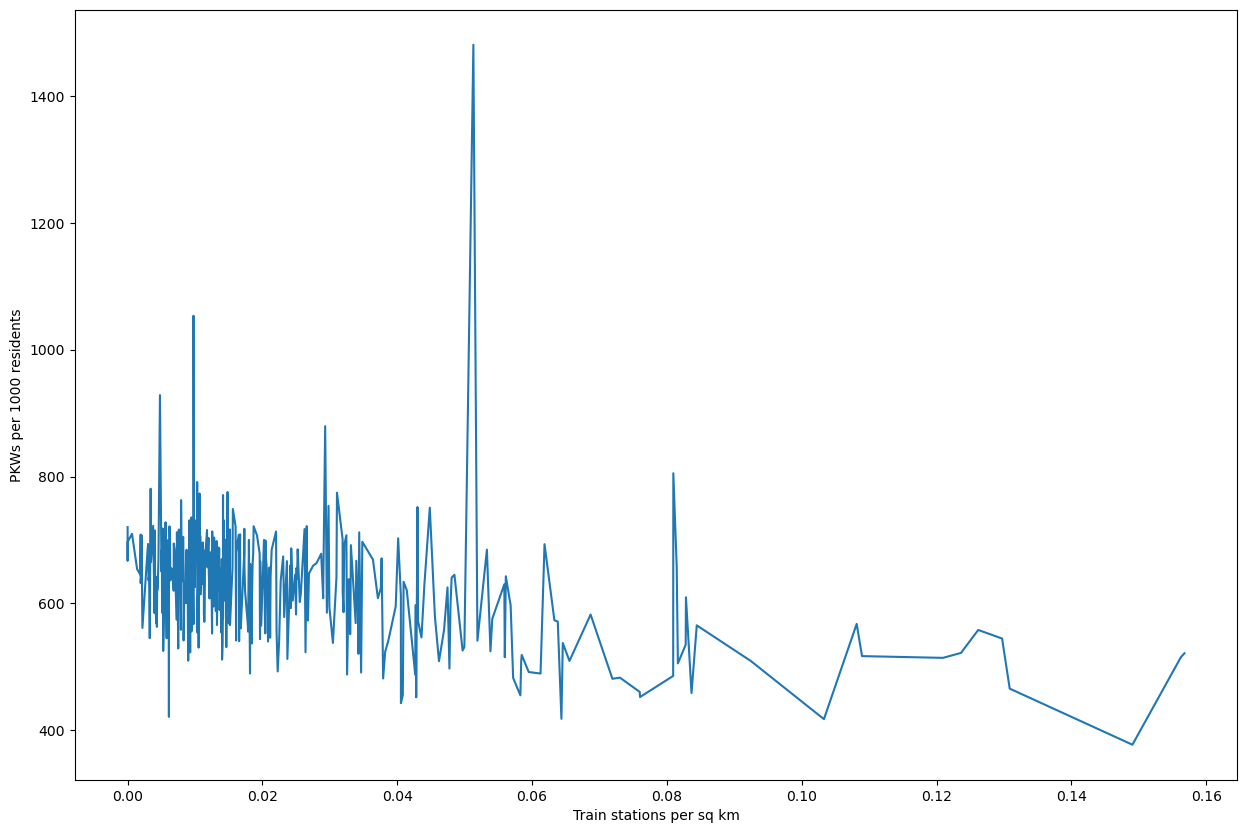

In [4]:
final.sort_values(by=['Train Stations per qkm'], inplace=True)
x = final['Train Stations per qkm']
y = final['Number of PKWs per 1000 residents']
plt.figure(figsize=(15, 10))
plt.plot(x,y)
plt.ylabel('PKWs per 1000 residents')
plt.xlabel('Train stations per sq km')
plt.show()

### Averaged Diagramm
To get some noise out of the diagramm, the data is getting averaged in intervals for the following diagram.

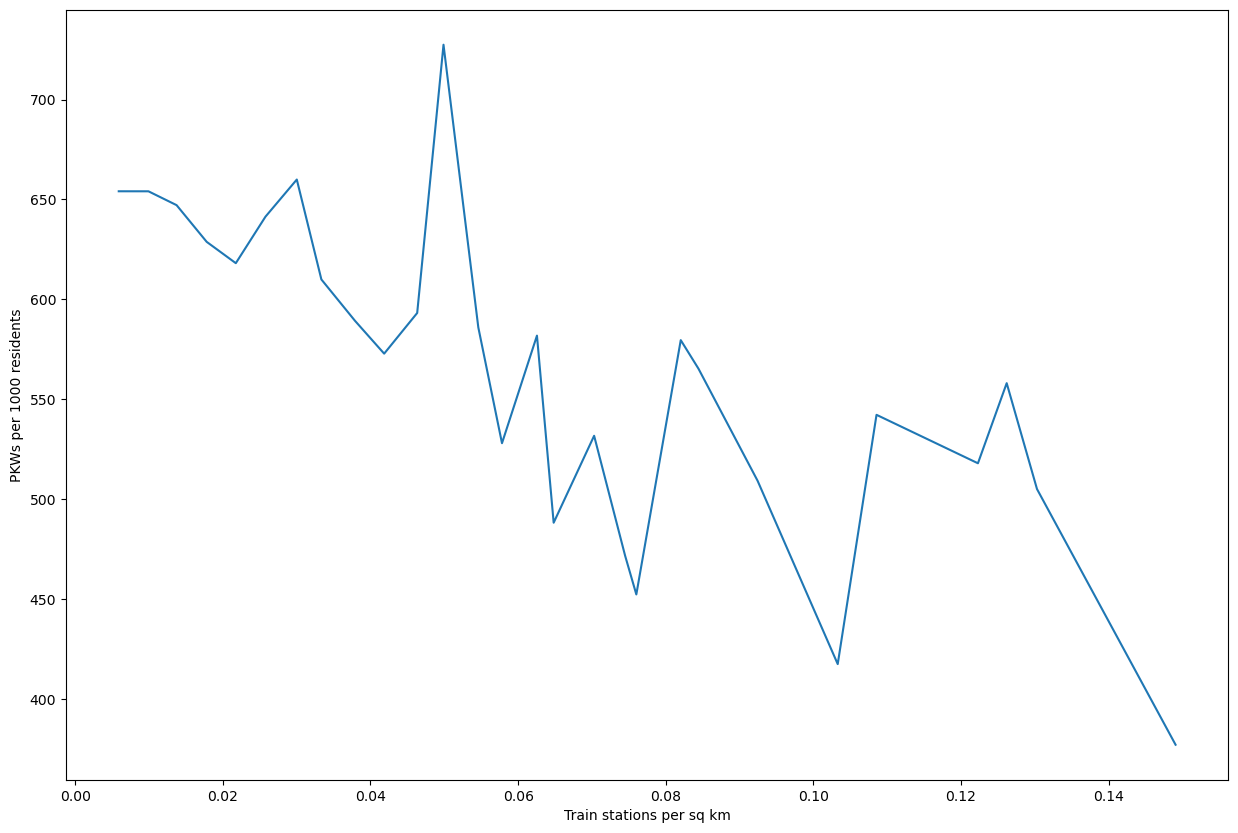

In [5]:
intervalBorders = [x / 250 for x in range(1, 40)]
groupedData = final.groupby(pd.cut(final['Train Stations per qkm'], intervalBorders), as_index=False).sum()
groupedDataCounted = final.groupby(pd.cut(final['Train Stations per qkm'], intervalBorders), as_index=False).count()
finalSmoothed = groupedData.divide(groupedDataCounted, 1, int, float)
finalSmoothed.dropna(inplace=True)
x = finalSmoothed['Train Stations per qkm']
y = finalSmoothed['Number of PKWs per 1000 residents']
plt.figure(figsize=(15, 10))
plt.plot(x,y)
plt.ylabel('PKWs per 1000 residents')
plt.xlabel('Train stations per sq km')
plt.show()

### Extreme values
So here we take the 5% of communities with the most cars per 1000 residents (red) and the 5% of communities with the less cars per 1000 residents (blue) and compare their average number of train stations per square km.
The points in form of a rhombus are the average value of the top 5% (yellow) and the less 5% (cyan)

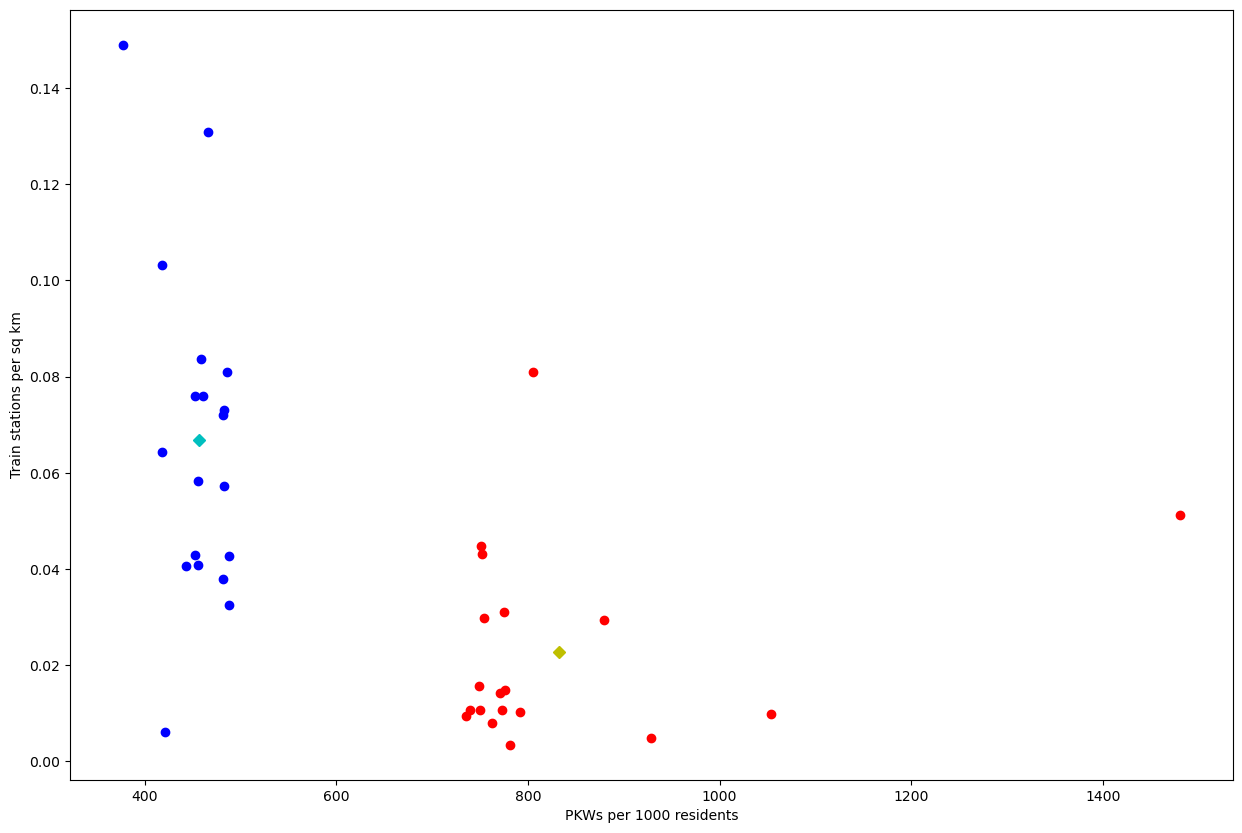

In [9]:
final.sort_values(by=['Number of PKWs per 1000 residents'], inplace=True)
less = final.head(n = int(final.shape[0]/20))
top = final.tail(n = int(final.shape[0]/20))
yt = top['Train Stations per qkm']
xt = top['Number of PKWs per 1000 residents']
yl = less['Train Stations per qkm']
xl = less['Number of PKWs per 1000 residents']
plt.figure(figsize=(15, 10))
plt.plot(xl,yl, 'bo', xt, yt, 'ro', top.mean(axis=0)['Number of PKWs per 1000 residents'],top.mean(axis=0)['Train Stations per qkm'], 'yD', less.mean(axis=0)['Number of PKWs per 1000 residents'],less.mean(axis=0)['Train Stations per qkm'], 'cD')
plt.xlabel('PKWs per 1000 residents')
plt.ylabel('Train stations per sq km')
plt.show()

## Conclusions
As we can see in the RAW diagramm the graph is not monotonically decreasing or increasing, so that we cannot make a general statement, that increasing the number of train stations per square km decreases the number of cars per 1000 residents. But already in the RAW diagramm we can recognize that it looks like the graph is going down in average, with increasing number of train stations per square km.
So to confirm this, we introduced the averaged diagramm, where we divided the data into 40 intervals and averaged these. And in the resulting diagramm we can clearly see a decreasing graph. Not monotonically but it's generally decreasing. 
To be honest, the result is not as clear as we hoped it would be. We can definitely see a tendency that the number of cars per 1000 residents decrease with increasing number of train stations per square km. But it's not steep decreasing. 
But to compare the extremes we took the average of the 5% of communities with the most cars per 1000 residents and the average of the 5% of communities with the less cars per 1000 residents and compare their average number of train stations per square km.
So we can say that increasing the number of train stations would probably decrease the number of cars and so decrease the exhaust gases.
As we can see in the diagramm with the extreme values, top 5% of the communities with the most cars per 1000 redidents (red) have, except for one community, all less than 0.06 train stations per sq km and more than half of these communitites are even under 0.02. So we can see, especially in communities with less than 0.02 train stations per sq km, the number of train stations should be increased to decrease the number of cars.
For the 5% of communities with the less cars per 1000 residents (blue), the diagram is not as clear as for the communities with the most cars per 1000 residents. But if we take the average of the top 5%, the average number of cars per 1000 residents is almost double of the average of the cars per 1000 residents in the less 5%. The average for the train stations for the top 5% is about 2.5 times the one for the less 5%. So for the extreme values we can assume, train stations times 2.5 means half as much cars.
So over all I think it's clear that increasing the number of train station, especially in areas with less than 0.02 train stations per sq km, would decrease the number of cars per 1000 residents, and so decrease the exhaust gases for better air quality and to became more climate friendly.